# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

# Task 2

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import math
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import shutil
import keras
from keras.models import Model

from typing import Union
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.models import Sequential

tf.enable_v2_behavior()

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir(r'/content/drive/My Drive/Colab Notebooks')

TRAIN_SIZE = 68
TEST_SIZE = 31
NUM_EPOCHS = 25
# NUM_CLASSES = 2
# NUM_SUBCLASSES = 8

Mounted at /content/drive


# Data loading

In [ ]:
annotations = pd.read_csv('annotations.csv')

anno_train = annotations.loc[annotations['Partition'] == 'train']
anno_test = annotations.loc[annotations['Partition'] == 'test']

anno_train.drop(['Partition', 'Number of Annotators who Selected SSA (Out of 7)'], axis=1, inplace=True)
anno_test.drop(['Partition', 'Number of Annotators who Selected SSA (Out of 7)'], axis=1, inplace=True)

anno_train = anno_train.rename(columns={'Majority Vote Label': 'label'})
anno_test = anno_test.rename(columns={'Majority Vote Label': 'label'})

anno_train = anno_train.astype({'label': str})
anno_test = anno_test.astype({'label': str})

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_img = anno_train['Image Name'].values
test_img = anno_test['Image Name'].values

# Referenced https://stackoverflow.com/questions/11903037/copy-all-jpg-file-in-a-directory-to-another-directory-in-python
# Referenced https://stackoverflow.com/questions/49237177/copying-multiple-images-in-a-list-from-one-folder-to-another-without-copying-all
src_dir = "images"
train_dir = "train"
test_dir = "test"

for im in train_img:
  shutil.copy(os.path.join(src_dir, im), train_dir)

for im in test_img:
  shutil.copy(os.path.join(src_dir, im), test_dir)

In [ ]:
# Referenced Project A.
# ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

# Referenced https://stackoverflow.com/questions/59464409/loading-images-in-keras-for-cnn-from-directory-but-label-in-csv-file
train_generator=train_datagen.flow_from_dataframe(
dataframe=anno_train,
directory="train",
x_col="Image Name",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224, 224))

test_generator=test_datagen.flow_from_dataframe(
dataframe=anno_test,
directory="test",
x_col="Image Name",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(224, 224))

Found 2175 validated image filenames belonging to 2 classes.
Found 977 validated image filenames belonging to 2 classes.


# Model creation

In [ ]:
# Referenced https://community.dataquest.io/t/fine-tuning-models/535120
# Teacher
teacher = Sequential()
resnet_model= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

resnet_model.trainable = True
set_trainable = False
for layer in resnet_model.layers:
    if layer.name in ['conv4_block1_preact_bn', 'conv5_block1_preact_bn']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

teacher.add(resnet_model)
teacher.add(Flatten())
teacher.add(Dense(2))

# Student
student = tf.keras.Sequential()
mobile_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

mobile_model.trainable = True
for layer in mobile_model.layers:
  layer.trainable = True

student.add(mobile_model)
student.add(Flatten())
student.add(Dense(2))


In [ ]:
# check the layer names
layers = [(layer, layer.name, layer.trainable) for layer in teacher.layers]
buff = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
# buff['Layer Name'].values
# buff

# Teacher loss function

In [ ]:
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = teacher(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3

  # Referenced https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class
  # bce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  # cross_entropy_loss_value = bce(labels, subclass_logits).numpy()

  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits)

  return cross_entropy_loss_value

# Student loss function

In [ ]:

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 2. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = student(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = teacher(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = ALPHA * tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits) + (1 - ALPHA) * distillation_loss_value
  
  return cross_entropy_loss_value

# Train and evaluation

In [ ]:
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  # your code start from here for step 4
  # reset train_generator
  train_generator.reset()

  # ---------------------------------------------------------- #
  # Tescher learning rate
  # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  # Student learning rate
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
  # ---------------------------------------------------------- #

  for epoch in range(1, NUM_EPOCHS + 1):
    train_generator.reset()
    
    # Run training.
    print('Epoch {}: '.format(epoch), end='')

    for i in range(TRAIN_SIZE):
      image_batch, label_batch=train_generator.next()

      with tf.GradientTape() as tape:
        # your code start from here for step 4
        # subclass_logits = model(images, training=True)
        loss_value = compute_loss_fn(image_batch, label_batch)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = 977

    test_generator.reset()
    for i in range(TEST_SIZE):
      image_test, label_test=test_generator.next()

      # your code start from here for step 4
      num_correct += compute_num_correct(model, image_test, label_test)[0].numpy()
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


# Training models

In [ ]:
# your code start from here for step 5 

# Teacher model
train_and_evaluate(teacher, compute_teacher_loss)

Epoch 1: Class_accuracy: 67.14%
Epoch 2: Class_accuracy: 73.80%
Epoch 3: Class_accuracy: 80.66%
Epoch 4: Class_accuracy: 79.63%
Epoch 5: Class_accuracy: 80.25%
Epoch 6: Class_accuracy: 83.52%
Epoch 7: Class_accuracy: 83.52%
Epoch 8: Class_accuracy: 84.54%
Epoch 9: Class_accuracy: 81.68%
Epoch 10: Class_accuracy: 84.34%
Epoch 11: Class_accuracy: 81.99%
Epoch 12: Class_accuracy: 84.44%
Epoch 13: Class_accuracy: 82.40%
Epoch 14: Class_accuracy: 78.40%
Epoch 15: Class_accuracy: 82.70%
Epoch 16: Class_accuracy: 81.58%
Epoch 17: Class_accuracy: 83.83%
Epoch 18: Class_accuracy: 80.35%
Epoch 19: Class_accuracy: 84.95%
Epoch 20: Class_accuracy: 84.75%
Epoch 21: Class_accuracy: 83.01%
Epoch 22: Class_accuracy: 83.52%
Epoch 23: Class_accuracy: 84.85%
Epoch 24: Class_accuracy: 83.01%
Epoch 25: Class_accuracy: 84.54%


In [ ]:
from keras.models import load_model

# teacher.save("teacher.h5")
teacher=load_model('teacher.h5')

In [ ]:
# Check loaded teacher model
num_correct = 0
num_total = 977

test_generator.reset()
for i in range(TEST_SIZE):
  image_test, label_test=test_generator.next()

  # your code start from here for step 4
  num_correct += compute_num_correct(teacher, image_test, label_test)[0].numpy()
print("Class_accuracy: " + '{:.2f}%'.format(
    num_correct / num_total * 100))

Class_accuracy: 84.54%


In [ ]:
# Student model
train_and_evaluate(student, compute_student_loss)

Epoch 1: Class_accuracy: 73.80%
Epoch 2: Class_accuracy: 80.14%
Epoch 3: Class_accuracy: 66.84%
Epoch 4: Class_accuracy: 77.18%
Epoch 5: Class_accuracy: 70.42%
Epoch 6: Class_accuracy: 68.37%
Epoch 7: Class_accuracy: 63.87%
Epoch 8: Class_accuracy: 64.38%
Epoch 9: Class_accuracy: 73.90%
Epoch 10: Class_accuracy: 80.25%
Epoch 11: Class_accuracy: 80.86%
Epoch 12: Class_accuracy: 72.88%
Epoch 13: Class_accuracy: 69.81%
Epoch 14: Class_accuracy: 64.18%
Epoch 15: Class_accuracy: 69.91%
Epoch 16: Class_accuracy: 68.88%
Epoch 17: Class_accuracy: 80.76%
Epoch 18: Class_accuracy: 75.44%
Epoch 19: Class_accuracy: 81.68%
Epoch 20: Class_accuracy: 81.17%
Epoch 21: Class_accuracy: 78.71%
Epoch 22: Class_accuracy: 78.81%
Epoch 23: Class_accuracy: 70.32%
Epoch 24: Class_accuracy: 84.75%
Epoch 25: Class_accuracy: 81.99%


In [ ]:
from keras.models import load_model

# student.save("student.h5")
student=load_model('student.h5')

In [ ]:
# Check loaded student model
num_correct = 0
num_total = 977

test_generator.reset()
for i in range(TEST_SIZE):
  image_test, label_test=test_generator.next()

  # your code start from here for step 4
  num_correct += compute_num_correct(student, image_test, label_test)[0].numpy()
print("Class_accuracy: " + '{:.2f}%'.format(
    num_correct / num_total * 100))

Class_accuracy: 81.99%


In [ ]:
# Tune task balance parameter
DISTILLATION_TEMPERATURE = 4.
tune_balance = [0, 0.2, 0.4, 0.6, 0.8, 1]
for i in tune_balance:
  ALPHA = i
  print("Task Balance: " + str(ALPHA))

  student = tf.keras.Sequential()
  mobile_model= tf.keras.applications.MobileNetV2(include_top=False,
                    input_shape=(224,224,3),
                    pooling='avg',classes=2,
                    weights='imagenet')

  mobile_model.trainable = True
  for layer in mobile_model.layers:
    layer.trainable = True

  student.add(mobile_model)
  student.add(Flatten())
  student.add(Dense(2))

  train_and_evaluate(student, compute_student_loss)

Task Balance: 0
Epoch 1: Class_accuracy: 63.15%
Epoch 2: Class_accuracy: 70.62%
Epoch 3: Class_accuracy: 66.63%
Epoch 4: Class_accuracy: 63.15%
Epoch 5: Class_accuracy: 64.07%
Epoch 6: Class_accuracy: 64.18%
Epoch 7: Class_accuracy: 63.25%
Epoch 8: Class_accuracy: 68.27%
Epoch 9: Class_accuracy: 71.03%
Epoch 10: Class_accuracy: 72.16%
Task Balance: 0.2
Epoch 1: Class_accuracy: 63.15%
Epoch 2: Class_accuracy: 66.63%
Epoch 3: Class_accuracy: 66.33%
Epoch 4: Class_accuracy: 63.46%
Epoch 5: Class_accuracy: 72.47%
Epoch 6: Class_accuracy: 74.72%
Epoch 7: Class_accuracy: 63.46%
Epoch 8: Class_accuracy: 66.43%
Epoch 9: Class_accuracy: 63.56%
Epoch 10: Class_accuracy: 65.71%
Task Balance: 0.4
Epoch 1: Class_accuracy: 63.15%
Epoch 2: Class_accuracy: 63.25%
Epoch 3: Class_accuracy: 63.25%
Epoch 4: Class_accuracy: 63.15%
Epoch 5: Class_accuracy: 63.25%
Epoch 6: Class_accuracy: 63.15%
Epoch 7: Class_accuracy: 63.15%
Epoch 8: Class_accuracy: 63.87%
Epoch 9: Class_accuracy: 65.30%
Epoch 10: Class_ac

# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
ALPHA = 0.5
tune_temp = [1., 2., 4., 16., 32., 64.]
for i in tune_temp:
  DISTILLATION_TEMPERATURE = i
  print("Temperature: " + str(DISTILLATION_TEMPERATURE))

  student = tf.keras.Sequential()
  mobile_model= tf.keras.applications.MobileNetV2(include_top=False,
                    input_shape=(224,224,3),
                    pooling='avg',classes=2,
                    weights='imagenet')

  mobile_model.trainable = True
  for layer in mobile_model.layers:
    layer.trainable = True

  student.add(mobile_model)
  student.add(Flatten())
  student.add(Dense(2))

  train_and_evaluate(student, compute_student_loss)

Temperature: 1.0
Epoch 1: Class_accuracy: 63.15%
Epoch 2: Class_accuracy: 63.15%
Epoch 3: Class_accuracy: 63.25%
Epoch 4: Class_accuracy: 63.15%
Epoch 5: Class_accuracy: 74.92%
Epoch 6: Class_accuracy: 71.95%
Epoch 7: Class_accuracy: 63.87%
Epoch 8: Class_accuracy: 76.97%
Epoch 9: Class_accuracy: 64.99%
Epoch 10: Class_accuracy: 71.65%
Temperature: 2.0
Epoch 1: Class_accuracy: 63.15%
Epoch 2: Class_accuracy: 63.25%
Epoch 3: Class_accuracy: 63.15%
Epoch 4: Class_accuracy: 79.32%
Epoch 5: Class_accuracy: 75.23%
Epoch 6: Class_accuracy: 76.87%
Epoch 7: Class_accuracy: 70.11%
Epoch 8: Class_accuracy: 73.18%
Epoch 9: Class_accuracy: 69.29%
Epoch 10: Class_accuracy: 72.26%
Temperature: 4.0
Epoch 1: Class_accuracy: 63.15%
Epoch 2: Class_accuracy: 63.15%
Epoch 3: Class_accuracy: 63.15%
Epoch 4: Class_accuracy: 63.15%
Epoch 5: Class_accuracy: 63.15%
Epoch 6: Class_accuracy: 64.69%
Epoch 7: Class_accuracy: 63.15%
Epoch 8: Class_accuracy: 63.15%
Epoch 9: Class_accuracy: 63.36%
Epoch 10: Class_acc

# Train student from scratch

In [ ]:
# Build fully connected student.
student_no_distillation = tf.keras.Sequential()
mobile_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

mobile_model.trainable = True
for layer in mobile_model.layers:
  layer.trainable = True

student_no_distillation.add(mobile_model)
student_no_distillation.add(Flatten())
student_no_distillation.add(Dense(2))

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = student_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)
  
  return cross_entropy_loss

# Student from scratch
train_and_evaluate(student_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 63.15%
Epoch 2: Class_accuracy: 63.25%
Epoch 3: Class_accuracy: 63.36%
Epoch 4: Class_accuracy: 63.66%
Epoch 5: Class_accuracy: 63.46%
Epoch 6: Class_accuracy: 63.15%
Epoch 7: Class_accuracy: 63.15%
Epoch 8: Class_accuracy: 63.25%
Epoch 9: Class_accuracy: 63.15%
Epoch 10: Class_accuracy: 63.25%
Epoch 11: Class_accuracy: 69.40%
Epoch 12: Class_accuracy: 63.25%
Epoch 13: Class_accuracy: 66.94%
Epoch 14: Class_accuracy: 67.14%
Epoch 15: Class_accuracy: 72.36%
Epoch 16: Class_accuracy: 67.35%
Epoch 17: Class_accuracy: 74.10%
Epoch 18: Class_accuracy: 69.91%
Epoch 19: Class_accuracy: 77.58%
Epoch 20: Class_accuracy: 69.70%
Epoch 21: Class_accuracy: 77.07%
Epoch 22: Class_accuracy: 70.83%
Epoch 23: Class_accuracy: 74.72%
Epoch 24: Class_accuracy: 72.47%
Epoch 25: Class_accuracy: 78.81%


# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
# your code start from here for step 8
!pip install keras-flops
from keras_flops import get_flops

print("--------------------------------------------------------------------------------------------")

teacher.summary()
student.summary()

teacher_flops = get_flops(teacher, batch_size=1)
student_flops = get_flops(student, batch_size=1)
print("FLOPs of Teacher Model: " + str(teacher_flops))
print("FLOPs of Student Model: " + str(student_flops))

     |████████████████████████████████| 462 kB 32.5 MB/s 
--------------------------------------------------------------------------------------------
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_34 (Flatten)        (None, 2048)              0         
                                                                 
 dense_60 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 22,077,442
Non-trainable params: 1,491,456
_________________________________________________________________
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Pa

# XAI method to explain models

In [ ]:
# your code start from here for step 9
# Refered to the notebooks of Project 1
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir(r'/content/drive/My Drive/Colab Notebooks')

from xai_utils import *


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_sample = 0
label_sample = 0
test_generator.reset()
for i in range(TEST_SIZE):
  image_test, label_test=test_generator.next()
  image_sample = image_test[0]
  label_sample = label_test[0]
  break

# RISE
# teacher model
explanation_map_teacher = RISE(image_sample, teacher, class_index=np.argmax(label_sample) ,N_MASKS=1000)
explanation_map_teacher -= explanation_map_teacher.min()
explanation_map_teacher /= explanation_map_teacher.max()+10e-30

# student model with distillation
explanation_map_student = RISE(image_sample, student, class_index=np.argmax(label_sample) ,N_MASKS=1000)
explanation_map_student -= explanation_map_student.min()
explanation_map_student /= explanation_map_student.max()+10e-30

# student model without distillation
explanation_map_student_nd = RISE(image_sample, student_no_distillation, class_index=np.argmax(label_sample) ,N_MASKS=1000)
explanation_map_student_nd -= explanation_map_student_nd.min()
explanation_map_student_nd /= explanation_map_student_nd.max()+10e-30

# # Grad-Cam
# # teacher
# explanation_grad_teacher = grad_cam(teacher, image_sample, 'flatten_34')
# explanation_grad_teacher -= explanation_grad_teacher.min()
# explanation_grad_teacher /= explanation_grad_teacher.max()+10e-30

# # student
# explanation_grad_student = grad_cam(student, np.expand_dims(image_sample, axis=0), 'flatten_80')
# explanation_grad_student -= explanation_grad_student.min()
# explanation_grad_student /= explanation_grad_student.max()+10e-30

# # student without distillation
# explanation_grad_scra = grad_cam(student_no_distillation, np.expand_dims(image_sample, axis=0), 'flatten_5')
# explanation_grad_scra -= explanation_grad_scra.min()
# explanation_grad_scra /= explanation_grad_scra.max()+10e-30

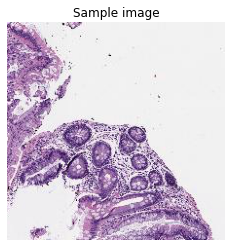

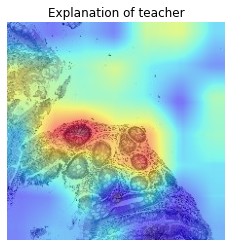

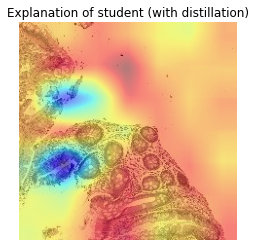

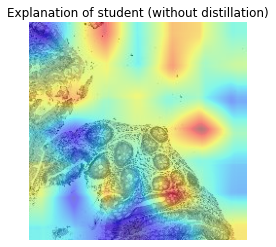

In [ ]:
import matplotlib.pyplot as plt

# RISE
# plt.subplot(1,4,1)
plt.imshow(np.squeeze(image_sample), cmap="gray")
plt.axis('off')
plt.title('Sample image')
plt.show()

# plt.subplot(1,4,2)
plt.imshow(np.squeeze(image_sample), cmap="gray")
plt.imshow(explanation_map_teacher, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation of teacher')
plt.show()

# plt.subplot(1,4,3)
plt.imshow(np.squeeze(image_sample), cmap="gray")
plt.imshow(explanation_map_student, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation of student (with distillation)')
plt.show()

# plt.subplot(1,4,4)
plt.imshow(np.squeeze(image_sample), cmap="gray")
plt.imshow(explanation_map_student_nd, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation of student (without distillation)')
plt.show()

# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 13

In [ ]:
# Referenced https://github.com/google-research/google-research/tree/01d59138d2a41465b25cdbb569524ad6ba1faaf1/subclass_distillation

# Cited as:
# @article{muller2020subclass,
# title={Subclass distillation},
# author={M{\"u}ller, Rafael and Kornblith, Simon and Hinton, Geoffrey},
# journal={arXiv preprint arXiv:2002.03936},
# year={2020}
# }

In [ ]:
NUM_CLASSES = 2
NUM_SUBCLASSES = 8
ALPHA = 0.5
DISTILLATION_TEMPERATURE = 2.
BETA = 1.0
AUXILIARY_TEMPERATURE = 1.0
NUM_EPOCHS = 25

In [ ]:
annotations = pd.read_csv('annotations.csv')

anno_train = annotations.loc[annotations['Partition'] == 'train']
anno_test = annotations.loc[annotations['Partition'] == 'test']

# The nature subclasses are the number of votes for am image
# And the classes are SSA and HP, as usual
# However, we do not to obtain the subclass information of an image from the dataset
# Just get the true class labels here is enough. So just preprocess the dataset as before

anno_train.drop(['Partition', 'Number of Annotators who Selected SSA (Out of 7)'], axis=1, inplace=True)
anno_test.drop(['Partition', 'Number of Annotators who Selected SSA (Out of 7)'], axis=1, inplace=True)

anno_train = anno_train.rename(columns={'Majority Vote Label': 'label'})
anno_test = anno_test.rename(columns={'Majority Vote Label': 'label'})

anno_train = anno_train.astype({'label': str})
anno_test = anno_test.astype({'label': str})

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Referenced Project A.
# ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

# Referenced https://stackoverflow.com/questions/59464409/loading-images-in-keras-for-cnn-from-directory-but-label-in-csv-file
train_generator=train_datagen.flow_from_dataframe(
dataframe=anno_train,
directory="train",
x_col="Image Name",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224, 224))

test_generator=test_datagen.flow_from_dataframe(
dataframe=anno_test,
directory="test",
x_col="Image Name",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(224, 224))

Found 2175 validated image filenames belonging to 2 classes.
Found 977 validated image filenames belonging to 2 classes.


In [ ]:
# Teacher
teacher = Sequential()
resnet_model= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

resnet_model.trainable = True
set_trainable = False
for layer in resnet_model.layers:
    if layer.name in ['conv4_block1_preact_bn', 'conv5_block1_preact_bn']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

teacher.add(resnet_model)
teacher.add(Flatten())
teacher.add(Dense(8))

# Student
student = tf.keras.Sequential()
mobile_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

mobile_model.trainable = True
for layer in mobile_model.layers:
  layer.trainable = True

student.add(mobile_model)
student.add(Flatten())
student.add(Dense(8))

In [ ]:
# teacher functions
def auxiliary_loss(subclass_logits: tf.Tensor, temperature: Union[float, tf.Tensor]):

  # convert to tensor
  temperature = tf.convert_to_tensor(temperature, dtype=subclass_logits.dtype)

  # needed for normalization
  mean, vari = tf.nn.moments(subclass_logits, -1, keepdims=True)
  num_subclasses = tf.convert_to_tensor(NUM_SUBCLASSES / NUM_CLASSES, dtype=subclass_logits.dtype)

  # Use the value of the official implementation
  e = tf.convert_to_tensor(1e-9, dtype=subclass_logits.dtype)

  # normalized vi hat
  vi = tf.nn.batch_normalization(subclass_logits, mean=mean, variance=vari, offset=None, scale=1./ tf.sqrt(temperature * num_subclasses), variance_epsilon=e)
  n = tf.cast(32, subclass_logits.dtype)

  products = tf.linalg.matmul(vi, vi, transpose_b=True)
  return (tf.math.reduce_mean(tf.math.reduce_logsumexp(products, -1)) - 1/temperature -tf.math.log(n))

def compute_teacher_loss(images, labels):

  subclass_logits = teacher(images, training=True)

  # cross entropy 
  subclass_logits = tf.reshape(subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, class_logits)

  # auxiliary loss
  auxiliary_loss_value = auxiliary_loss(subclass_logits, AUXILIARY_TEMPERATURE)

  # total loss value
  loss_value = cross_entropy_loss_value + BETA * auxiliary_loss_value

  return loss_value

In [ ]:
# student
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor, temperature: Union[float, tf.Tensor]):

  soft_targets = tf.nn.softmax(teacher_logits / temperature)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2


def compute_student_loss(images, labels):

  student_subclass_logits = student(images, training=True)

  teacher_subclass_logits = teacher(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  subclass_logits = tf.reshape(student_subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)

  cross_entropy_loss_value = ALPHA * tf.nn.softmax_cross_entropy_with_logits(labels, class_logits) + (1 - ALPHA) * distillation_loss_value
  return cross_entropy_loss_value

In [ ]:
# Train and evaluation
def compute_num_correct(model, images, labels):

  subclass_logits = model(images, training=False)
  subclass_logits = tf.reshape(subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)

  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)

def train_and_evaluate(model, compute_loss_fn):

  train_generator.reset()

  # ---------------------------------------------------------- #
  # Tescher learning rate
  # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  # Student learning rate
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
  # ---------------------------------------------------------- #

  for epoch in range(1, NUM_EPOCHS + 1):
    train_generator.reset()
    
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for i in range(TRAIN_SIZE):
      image_batch, label_batch=train_generator.next()
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(image_batch, label_batch)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = 977

    test_generator.reset()
    for i in range(TEST_SIZE):
      image_test, label_test=test_generator.next()

      # your code start from here for step 4
      num_correct += compute_num_correct(model, image_test, label_test)[0].numpy()
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

In [ ]:
# train teacher
train_and_evaluate(teacher, compute_teacher_loss)

Epoch 1: Class_accuracy: 69.29%
Epoch 2: Class_accuracy: 77.07%
Epoch 3: Class_accuracy: 81.37%
Epoch 4: Class_accuracy: 75.64%
Epoch 5: Class_accuracy: 76.66%
Epoch 6: Class_accuracy: 75.74%
Epoch 7: Class_accuracy: 83.42%
Epoch 8: Class_accuracy: 81.06%
Epoch 9: Class_accuracy: 80.55%
Epoch 10: Class_accuracy: 77.79%
Epoch 11: Class_accuracy: 83.32%
Epoch 12: Class_accuracy: 83.52%
Epoch 13: Class_accuracy: 82.80%
Epoch 14: Class_accuracy: 83.42%
Epoch 15: Class_accuracy: 82.40%
Epoch 16: Class_accuracy: 80.96%
Epoch 17: Class_accuracy: 81.58%
Epoch 18: Class_accuracy: 81.88%
Epoch 19: Class_accuracy: 82.91%
Epoch 20: Class_accuracy: 83.83%
Epoch 21: Class_accuracy: 81.27%
Epoch 22: Class_accuracy: 82.29%
Epoch 23: Class_accuracy: 82.09%
Epoch 24: Class_accuracy: 83.52%
Epoch 25: Class_accuracy: 83.21%


In [ ]:
from keras.models import load_model

# teacher.save("teacher_sub.h5")
teacher=load_model('teacher_sub.h5')

In [ ]:
# train student
train_and_evaluate(student, compute_student_loss)

Epoch 1: Class_accuracy: 76.56%
Epoch 2: Class_accuracy: 76.25%
Epoch 3: Class_accuracy: 75.74%
Epoch 4: Class_accuracy: 68.88%
Epoch 5: Class_accuracy: 68.88%
Epoch 6: Class_accuracy: 75.64%
Epoch 7: Class_accuracy: 74.41%
Epoch 8: Class_accuracy: 76.87%
Epoch 9: Class_accuracy: 76.77%
Epoch 10: Class_accuracy: 79.22%
Epoch 11: Class_accuracy: 81.27%
Epoch 12: Class_accuracy: 76.05%
Epoch 13: Class_accuracy: 66.33%
Epoch 14: Class_accuracy: 69.81%
Epoch 15: Class_accuracy: 76.05%
Epoch 16: Class_accuracy: 78.30%
Epoch 17: Class_accuracy: 79.94%
Epoch 18: Class_accuracy: 81.78%
Epoch 19: Class_accuracy: 82.60%
Epoch 20: Class_accuracy: 75.33%
Epoch 21: Class_accuracy: 74.72%
Epoch 22: Class_accuracy: 78.92%
Epoch 23: Class_accuracy: 76.25%
Epoch 24: Class_accuracy: 77.48%
Epoch 25: Class_accuracy: 79.84%


# Draw graphs base on generated datum

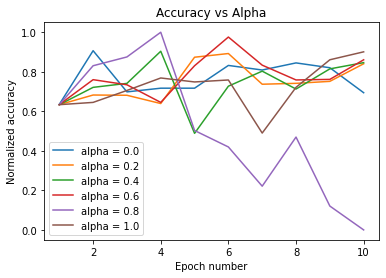

In [ ]:
import matplotlib.pyplot as plt

# tune alpha
balance_1_00 = np.array([63.15, 70.83, 63.25, 67.04, 60.18, 72.06, 71.03, 78.30, 73.18, 69.91])
balance_1_02 = np.array([63.15, 63.15, 63.15, 63.25, 63.15, 64.07, 70.21, 66.33, 69.40, 75.33])
balance_1_04 = np.array([63.15, 63.15, 65.40, 74.00, 64.18, 65.10, 68.47, 63.25, 63.66, 73.18])
balance_1_06 = np.array([63.15, 63.15, 63.87, 63.15, 70.52, 74.21, 60.70, 69.29, 64.99, 63.66])
balance_1_08 = np.array([63.15, 73.39, 62.74, 67.55, 40.63, 39.92, 39.30, 54.86, 50.05, 52.92])
balance_1_10 = np.array([63.15, 63.56, 67.76, 71.85, 64.89, 64.89, 37.46, 62.85, 69.40, 72.77])

balance_2_00 = np.array([63.25, 67.45, 64.18, 65.20, 71.14, 67.35, 67.66, 57.93, 58.55, 51.69])
balance_2_02 = np.array([63.15, 63.15, 63.36, 63.15, 70.93, 69.09, 63.15, 64.38, 64.89, 63.15])
balance_2_04 = np.array([63.15, 69.29, 68.47, 71.55, 51.69, 67.86, 69.91, 67.96, 73.39, 68.27])
balance_2_06 = np.array([63.15, 64.79, 69.60, 63.46, 68.37, 74.10, 75.13, 64.38, 68.37, 65.71])
balance_2_08 = np.array([63.15, 66.94, 68.37, 71.44, 68.27, 61.62, 72.06, 51.89, 59.47, 43.40])
balance_2_10 = np.array([63.15, 63.15, 63.15, 63.15, 63.15, 63.25, 63.15, 63.15, 63.87, 63.25])

balance_3_00 = np.array([63.15, 70.62, 66.63, 63.15, 64.07, 64.18, 63.25, 68.27, 71.03, 72.16])
balance_3_02 = np.array([63.15, 66.63, 66.33, 63.46, 72.47, 74.72, 63.46, 66.43, 63.56, 65.71])
balance_3_04 = np.array([63.15, 63.25, 63.25, 63.15, 63.25, 63.15, 63.15, 63.87, 65.30, 63.15])
balance_3_06 = np.array([63.15, 70.52, 63.15, 63.66, 64.59, 65.51, 67.86, 64.69, 65.20, 76.25])
balance_3_08 = np.array([63.15, 63.15, 75.54, 76.56, 71.24, 72.67, 48.72, 71.03, 43.40, 48.00])
balance_3_10 = np.array([63.15, 63.56, 63.66, 64.07, 69.60, 70.21, 78.61, 69.70, 72.36, 72.47])

balance00 = (np.mean(np.array([balance_1_00, balance_2_00, balance_3_00]), axis=0))
balance02 = (np.mean(np.array([balance_1_02, balance_2_02, balance_3_02]), axis=0))
balance04 = (np.mean(np.array([balance_1_04, balance_2_04, balance_3_04]), axis=0))
balance06 = (np.mean(np.array([balance_1_06, balance_2_06, balance_3_06]), axis=0))
balance08 = (np.mean(np.array([balance_1_08, balance_2_08, balance_3_08]), axis=0))
balance10 = (np.mean(np.array([balance_1_10, balance_2_10, balance_3_10]), axis=0))

max_value = np.amax([balance00, balance02, balance04, balance06, balance08, balance10])
min_value = np.amin([balance00, balance02, balance04, balance06, balance08, balance10])

balance00 = (np.mean(np.array([balance_1_00, balance_2_00, balance_3_00]), axis=0) -min_value) / (max_value - min_value)
balance02 = (np.mean(np.array([balance_1_02, balance_2_02, balance_3_02]), axis=0) -min_value) / (max_value - min_value)
balance04 = (np.mean(np.array([balance_1_04, balance_2_04, balance_3_04]), axis=0) -min_value) / (max_value - min_value)
balance06 = (np.mean(np.array([balance_1_06, balance_2_06, balance_3_06]), axis=0) -min_value) / (max_value - min_value)
balance08 = (np.mean(np.array([balance_1_08, balance_2_08, balance_3_08]), axis=0) -min_value) / (max_value - min_value)
balance10 = (np.mean(np.array([balance_1_10, balance_2_10, balance_3_10]), axis=0) -min_value) / (max_value - min_value)

x = list(range(1, 11))

plt.figure(1)
plt.plot(x, balance00, label = "alpha = 0.0")
plt.plot(x, balance02, label = "alpha = 0.2")
plt.plot(x, balance04, label = "alpha = 0.4")
plt.plot(x, balance06, label = "alpha = 0.6")
plt.plot(x, balance08, label = "alpha = 0.8")
plt.plot(x, balance10, label = "alpha = 1.0")

plt.title('Accuracy vs Alpha')
plt.ylabel('Normalized accuracy')
plt.xlabel('Epoch number')
plt.legend(loc='best')
plt.show()


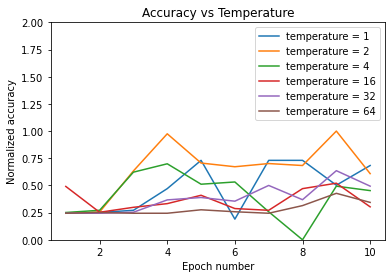

In [ ]:
# tune temperature
temp_1_01 = [63.15, 63.15, 63.56, 64.48, 73.08, 72.47, 76.66, 69.50, 60.59, 70.11]
temp_1_02 = [63.15, 63.56, 74.21, 79.22, 67.45, 68.78, 76.87, 69.60, 74.41, 69.60]
temp_1_04 = [63.15, 63.15, 68.58, 68.58, 63.15, 63.15, 63.25, 63.15, 64.28, 66.12]
temp_1_16 = [63.15, 63.15, 63.56, 63.46, 63.87, 63.56, 63.25, 69.19, 68.99, 65.30]
temp_1_32 = [63.15, 63.15, 63.36, 68.70, 67.96, 67.25, 65.61, 69.19, 68.37, 63.15]
temp_1_64 = [63.15, 63.15, 63.15, 63.15, 63.15, 63.15, 63.15, 63.46, 63.15, 63.15]

temp_2_01 = [63.15, 63.46, 63.87, 72.06, 63.46, 42.58, 70.93, 64.99, 75.54, 67.55]
temp_2_02 = [63.15, 63.15, 69.70, 63.97, 67.66, 63.15, 63.15, 66.53, 79.94, 64.07]
temp_2_04 = [63.46, 64.38, 74.82, 78.30, 75.23, 74.62, 63.66, 52.10, 73.08, 66.94]
temp_2_16 = [63.15, 63.15, 64.59, 66.53, 63.36, 64.69, 64.28, 66.94, 63.15, 63.15]
temp_2_32 = [63.15, 63.15, 63.36, 63.15, 64.89, 64.07, 72.26, 62.74, 75.64, 74.21]
temp_2_64 = [63.15, 63.15, 63.15, 63.15, 63.15, 63.77, 63.15, 65.40, 71.44, 67.25]

temp_3_01 = [63.15, 63.15, 63.25, 63.15, 74.92, 71.95, 63.87, 76.97, 64.99, 71.65]
temp_3_02 = [63.15, 63.25, 63.15, 79.32, 75.23, 76.87, 70.11, 73.18, 69.29, 72.26]
temp_3_04 = [63.15, 63.15, 63.15, 63.15, 63.15, 64.69, 63.15, 63.15, 63.36, 65.81]
temp_3_16 = [74.31, 63.56, 63.77, 63.46, 69.70, 63.15, 63.15, 63.56, 69.81, 63.66]
temp_3_32 = [63.15, 63.15, 63.15, 63.15, 63.15, 63.15, 63.15, 63.15, 63.15, 63.36]
temp_3_64 = [63.15, 63.46, 63.15, 63.15, 64.59, 63.15, 63.15, 63.77, 63.15, 63.56]

temp01 = (np.mean(np.array([temp_1_01, temp_2_01, temp_3_01]), axis=0))
temp02 = (np.mean(np.array([temp_1_02, temp_2_02, temp_3_02]), axis=0))
temp04 = (np.mean(np.array([temp_1_04, temp_2_04, temp_3_04]), axis=0))
temp16 = (np.mean(np.array([temp_1_16, temp_2_16, temp_3_16]), axis=0))
temp32 = (np.mean(np.array([temp_1_32, temp_2_32, temp_3_32]), axis=0))
temp64 = (np.mean(np.array([temp_1_64, temp_2_64, temp_3_64]), axis=0))

max_value = np.amax([temp01, temp02, temp04, temp16, temp32, temp64])
min_value = np.amin([temp01, temp02, temp04, temp16, temp32, temp64])

temp01 = (np.mean(np.array([temp_1_01, temp_2_01, temp_3_01]), axis=0) -min_value) / (max_value - min_value)
temp02 = (np.mean(np.array([temp_1_02, temp_2_02, temp_3_02]), axis=0) -min_value) / (max_value - min_value)
temp04 = (np.mean(np.array([temp_1_04, temp_2_04, temp_3_04]), axis=0) -min_value) / (max_value - min_value)
temp16 = (np.mean(np.array([temp_1_16, temp_2_16, temp_3_16]), axis=0) -min_value) / (max_value - min_value)
temp32 = (np.mean(np.array([temp_1_32, temp_2_32, temp_3_32]), axis=0) -min_value) / (max_value - min_value)
temp64 = (np.mean(np.array([temp_1_64, temp_2_64, temp_3_64]), axis=0) -min_value) / (max_value - min_value)

x = list(range(1, 11))

plt.figure(1)
plt.plot(x, temp01, label = "temperature = 1")
plt.plot(x, temp02, label = "temperature = 2")
plt.plot(x, temp04, label = "temperature = 4")
plt.plot(x, temp16, label = "temperature = 16")
plt.plot(x, temp32, label = "temperature = 32")
plt.plot(x, temp64, label = "temperature = 64")

plt.title('Accuracy vs Temperature')
plt.ylabel('Normalized accuracy')
plt.ylim(0.0, 2)
plt.xlabel('Epoch number')
plt.legend(loc='best')
plt.show()


### Archive

In [ ]:
# teacher.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#               metrics=['accuracy'])

# teacher.fit_generator(generator=train_generator,
#                     steps_per_epoch=train_generator.n // 32,
#                     epochs=25,                 
#                     shuffle = True,
#                     verbose=1)